In [1]:
import pandas as pd 

In [3]:
descriptors = {}
for n_variables in [3,5,10,20,50]:
        descriptors[n_variables] = {}
        for noise_std in [0.01, 0.1, 0.3]:
            
            output_folder = f'data_N{n_variables}_std{noise_std}/'
            file_name = 'descriptors_Ridgefamily-0-1-2-3-4-5.pkl'

            descriptors[n_variables][noise_std] = pd.read_pickle('../'+output_folder + file_name)


In [15]:
descriptors[3][0.01].columns[3:-2]

Index(['coefficient_ca', 'coefficient_ef', 'ca_ef_given_common_causes',
       'ef_ca_given_MBef', 'ca_ef_given_MBca', 'ef_ca_given_MBca_plus_MBef_0',
       'ef_ca_given_MBca_plus_MBef_1', 'ef_ca_given_MBca_plus_MBef_2',
       'ef_ca_given_MBca_plus_MBef_3', 'ef_ca_given_MBca_plus_MBef_4',
       'ef_ca_given_MBca_plus_MBef_5', 'ef_ca_given_MBca_plus_MBef_6',
       'ca_ef_given_MBef_plus_MBca_0', 'ca_ef_given_MBef_plus_MBca_1',
       'ca_ef_given_MBef_plus_MBca_2', 'ca_ef_given_MBef_plus_MBca_3',
       'ca_ef_given_MBef_plus_MBca_4', 'ca_ef_given_MBef_plus_MBca_5',
       'ca_ef_given_MBef_plus_MBca_6', 'ca_ef', 'ef_ca', 'MBef_ca_0',
       'MBef_ca_1', 'MBef_ca_2', 'MBef_ca_3', 'MBef_ca_4', 'MBef_ca_5',
       'MBef_ca_6', 'MBca_ef_0', 'MBca_ef_1', 'MBca_ef_2', 'MBca_ef_3',
       'MBca_ef_4', 'MBca_ef_5', 'MBca_ef_6', 'ca_MBef_given_ef_0',
       'ca_MBef_given_ef_1', 'ca_MBef_given_ef_2', 'ca_MBef_given_ef_3',
       'ca_MBef_given_ef_4', 'ca_MBef_given_ef_5', 'ca_MBef_given_ef

In [21]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

cross_validation_results = {}
for n_variables in tqdm([3,5,10,20,50]):
    cross_validation_results[n_variables] = {}
    for noise_std in tqdm([0.01, 0.1, 0.3]):
        df = descriptors[n_variables][noise_std].reset_index(drop=True)
        df['process'] = df.graph_id // 50 + 1
        # leave-one-process-out cross validation multiprocessing
        logo = LeaveOneGroupOut()
        logo.get_n_splits(df, groups=df.process)
        aucs = []

        columns_of_interest = df.columns[3:-2]
        for train_index, test_index in logo.split(df, df.is_causal, groups=df.process):
            X_train, X_test = df.iloc[train_index][columns_of_interest], df.iloc[test_index][columns_of_interest]
            y_train, y_test = df.is_causal.iloc[train_index], df.is_causal.iloc[test_index]
            clf = RandomForestClassifier(n_estimators=40, n_jobs=40)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            aucs.append(roc_auc_score(y_test, y_pred))
        cross_validation_results[n_variables][noise_std] = aucs


        

100%|██████████| 5/5 [08:34<00:00, 102.90s/it]


In [22]:
# pickle cross_validation_results
import pickle
with open('cross_validation_results.pkl', 'wb') as f:
    pickle.dump(cross_validation_results, f)

In [27]:
# load cross_validation_results
import pickle
with open('cross_validation_results.pkl', 'rb') as f:
    cross_validation_results = pickle.load(f)

,level_0,level_1,0
0,0.01,3,"[0.49267995444191337, 0.5451062417293864, 0.49..."
1,0.01,5,"[0.53725, 0.5110663983903422, 0.49697885196374..."
2,0.01,10,"[0.523, 0.52475, 0.51, 0.511, 0.72674999999999..."
3,0.01,20,"[0.5295000000000001, 0.528, 0.5155000000000001..."
4,0.01,50,"[0.5897499999999999, 0.538, 0.531, 0.57, 0.698..."
5,0.10,3,"[0.5755820045558088, 0.6380579376404985, 0.492..."
6,0.10,5,"[0.574, 0.721830985915493, 0.49043303121852966..."
7,0.10,10,"[0.55825, 0.7145, 0.5125000000000001, 0.5135, ..."
8,0.10,20,"[0.554, 0.69875, 0.51825, 0.5309999999999999, ..."
9,0.10,50,"[0.6515, 0.7414999999999999, 0.543750000000000..."


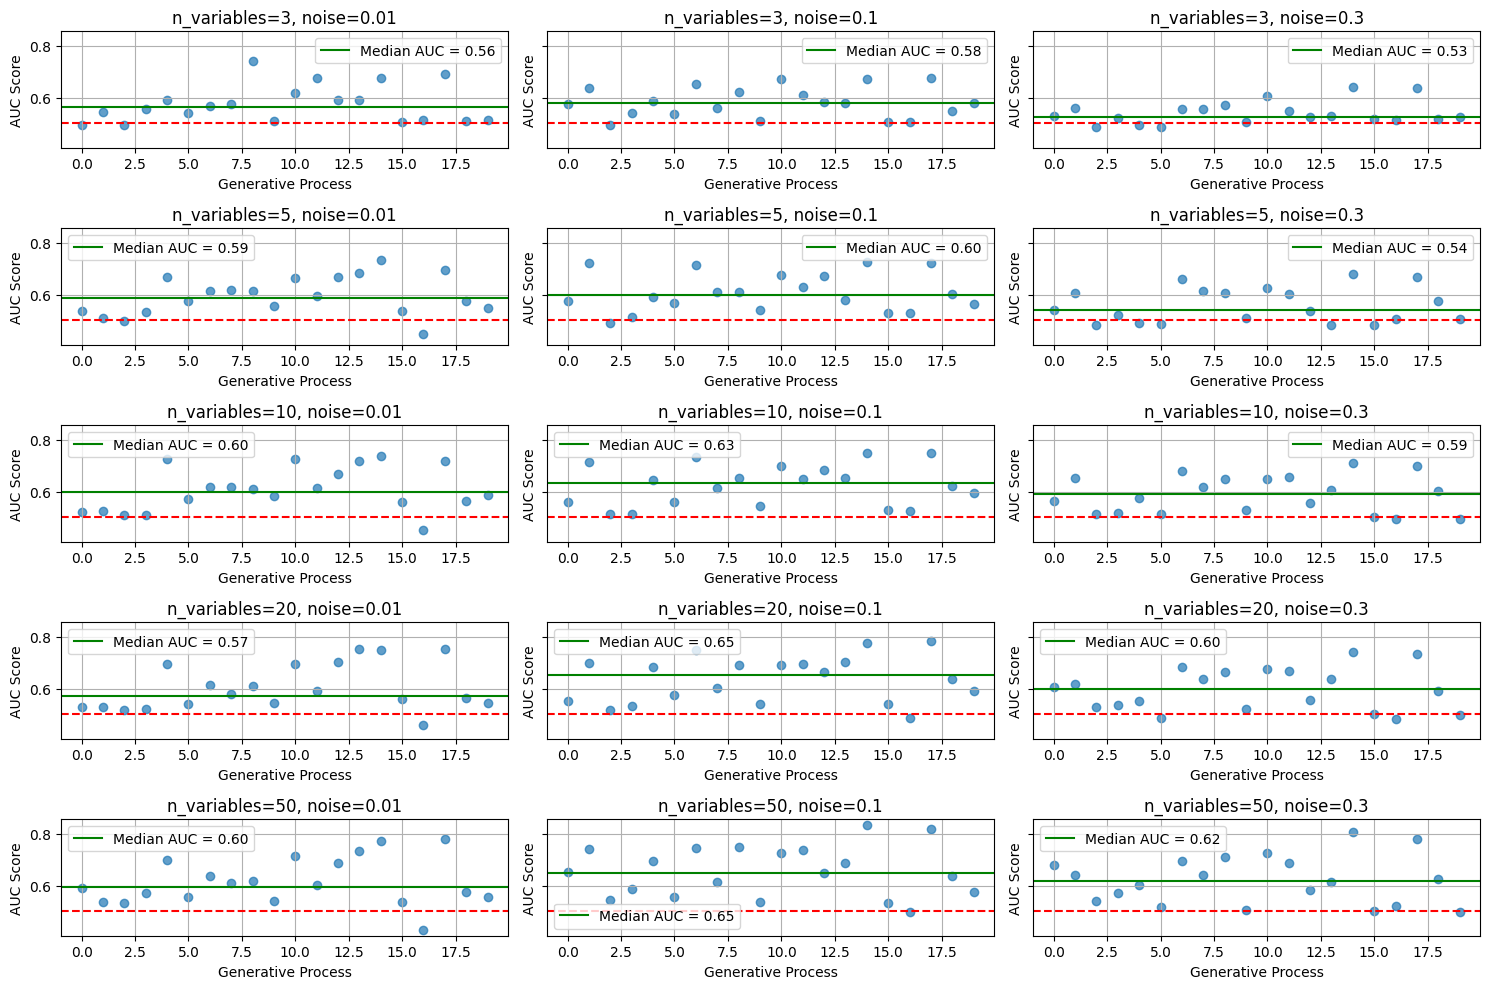

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_auc_distributions(data):
    # Create a figure and axis array
    fig, axs = plt.subplots(len(data.keys()), len(list(next(iter(data.values())).keys())), figsize=(15, 10), sharey=True)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    axs = axs.ravel()  # Flatten the axis array for easy iteration

    # Loop through each combination of n_variables and std of noise
    for i, (n_vars, noise_dict) in enumerate(data.items()):
        for j, (std_noise, auc_scores) in enumerate(noise_dict.items()):
            ax = axs[i * len(noise_dict) + j]
            ax.scatter(np.arange(len(auc_scores)), auc_scores, alpha=0.7)
            ax.axhline(y=0.5, color='r', linestyle='--')  # AUC = 0.5 line without legend entry
            median_auc = np.median(auc_scores)
            ax.axhline(y=median_auc, color='g', linestyle='-', label=f'Median AUC = {median_auc:.2f}')
            ax.set_title(f'n_variables={n_vars}, noise={std_noise}')
            ax.set_xlabel('Generative Process')
            ax.set_ylabel('AUC Score')
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    return fig

# Plot the updated AUC distributions with AUC line at 0.5
fig_updated = plot_auc_distributions(cross_validation_results)
plt.show()

In [31]:
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

cross_validation_results = {}
for n_variables in tqdm([3,5,10,20,50]):
    cross_validation_results[n_variables] = {}
    for noise_std in tqdm([0.01, 0.1, 0.3]):
        df = descriptors[n_variables][noise_std].reset_index(drop=True)
        df['process'] = df.graph_id // 50 + 1
        # leave-one-process-out cross validation multiprocessing
        logo = LeaveOneGroupOut()
        logo.get_n_splits(df, groups=df.process)
        aucs = []

        columns_of_interest = df.columns[3:-2]
        for train_index, test_index in logo.split(df, df.is_causal, groups=df.process):
            X_train, X_test = df.iloc[train_index][columns_of_interest], df.iloc[test_index][columns_of_interest]
            y_train, y_test = df.is_causal.iloc[train_index], df.is_causal.iloc[test_index]
            clf = BalancedRandomForestClassifier(n_estimators=40, n_jobs=40, max_depth=10, random_state=0, class_weight='balanced', sampling_strategy='auto', replacement=True)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            aucs.append(roc_auc_score(y_test, y_pred))
        cross_validation_results[n_variables][noise_std] = aucs


        

100%|██████████| 5/5 [06:37<00:00, 79.49s/it]


In [32]:
# pickle cross_validation_results
import pickle
with open('cross_validation_results_BRF.pkl', 'wb') as f:
    pickle.dump(cross_validation_results, f)

In [ ]:
# load cross_validation_results
import pickle
with open('cross_validation_results_BRF.pkl', 'rb') as f:
    cross_validation_results = pickle.load(f)

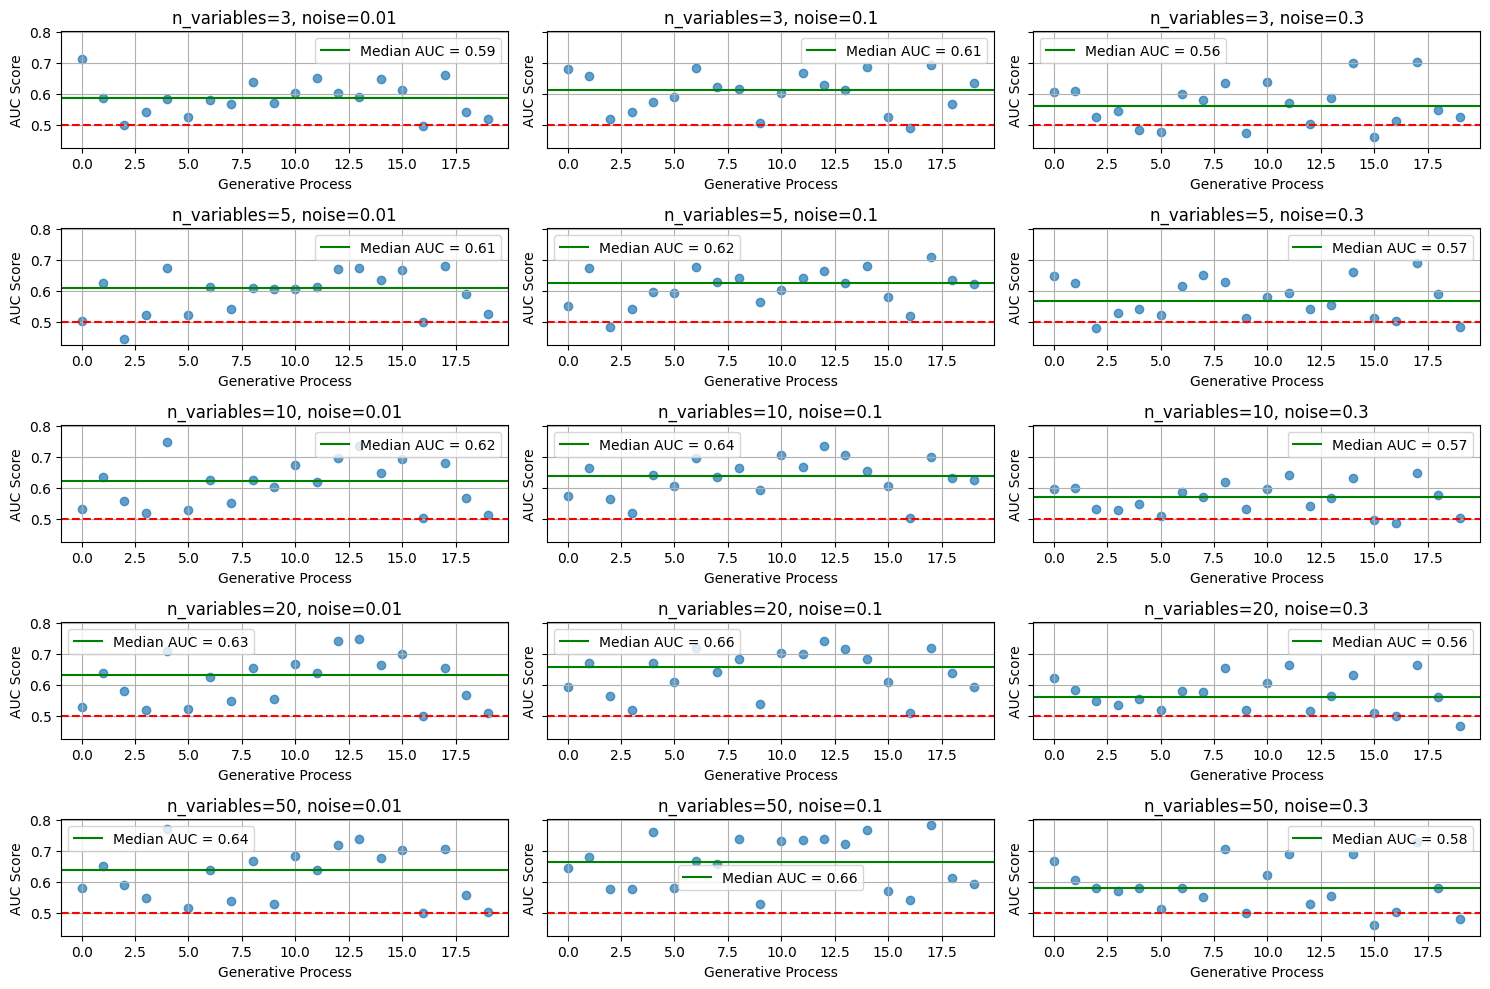

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_auc_distributions(data):
    # Create a figure and axis array
    fig, axs = plt.subplots(len(data.keys()), len(list(next(iter(data.values())).keys())), figsize=(15, 10), sharey=True)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    axs = axs.ravel()  # Flatten the axis array for easy iteration

    # Loop through each combination of n_variables and std of noise
    for i, (n_vars, noise_dict) in enumerate(data.items()):
        for j, (std_noise, auc_scores) in enumerate(noise_dict.items()):
            ax = axs[i * len(noise_dict) + j]
            ax.scatter(np.arange(len(auc_scores)), auc_scores, alpha=0.7)
            ax.axhline(y=0.5, color='r', linestyle='--')  # AUC = 0.5 line without legend entry
            median_auc = np.median(auc_scores)
            ax.axhline(y=median_auc, color='g', linestyle='-', label=f'Median AUC = {median_auc:.2f}')
            ax.set_title(f'n_variables={n_vars}, noise={std_noise}')
            ax.set_xlabel('Generative Process')
            ax.set_ylabel('AUC Score')
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    return fig

# Plot the updated AUC distributions with AUC line at 0.5
fig_updated = plot_auc_distributions(cross_validation_results)
plt.show()

In [34]:
# What happen if we merge all the data and train a single model?
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

cross_validation_results = {}

df = pd.concat([descriptors[n][std] for n in [3,5,10,20,50] for std in [0.01, 0.1, 0.3]]).reset_index(drop=True)
df['process'] = df.graph_id // 50 + 1
# leave-one-process-out cross validation multiprocessing
logo = LeaveOneGroupOut()
logo.get_n_splits(df, groups=df.process)
aucs = []

columns_of_interest = df.columns[3:-2]

for train_index, test_index in logo.split(df, df.is_causal, groups=df.process):
    X_train, X_test = df.iloc[train_index][columns_of_interest], df.iloc[test_index][columns_of_interest]
    y_train, y_test = df.is_causal.iloc[train_index], df.is_causal.iloc[test_index]
    clf = RandomForestClassifier(n_estimators=40, n_jobs=40)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    aucs.append(roc_auc_score(y_test, y_pred))
cross_validation_results['RandomForest'] = aucs



In [36]:
import pickle
with open('cross_validation_results_RF_merged.pkl', 'wb') as f:
    pickle.dump(cross_validation_results, f)

In [ ]:
import pickle
with open('cross_validation_results_RF_merged.pkl', 'rb') as f:
    cross_validation_results = pickle.load(f)

In [42]:
np.median(cross_validation_results['RandomForest']), np.mean(cross_validation_results['RandomForest']), np.std(cross_validation_results['RandomForest'])

(0.6058090102538055, 0.6024454401446377, 0.07347965823330713)

In [44]:
df.is_causal.value_counts()

0    573525
1    291477
Name: is_causal, dtype: int64

In [45]:
# What happen if we merge all the data and train a single model?
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

cross_validation_results = {}

df = pd.concat([descriptors[n][std] for n in [3,5,10,20,50] for std in [0.01, 0.1, 0.3]]).reset_index(drop=True)
df['process'] = df.graph_id // 50 + 1
# leave-one-process-out cross validation multiprocessing
logo = LeaveOneGroupOut()
logo.get_n_splits(df, groups=df.process)
aucs = []

columns_of_interest = df.columns[3:-2]

for train_index, test_index in logo.split(df, df.is_causal, groups=df.process):
    X_train, X_test = df.iloc[train_index][columns_of_interest], df.iloc[test_index][columns_of_interest]
    y_train, y_test = df.is_causal.iloc[train_index], df.is_causal.iloc[test_index]
    clf = BalancedRandomForestClassifier(n_estimators=40, n_jobs=40, max_depth=10, sampling_strategy='auto', replacement=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    aucs.append(roc_auc_score(y_test, y_pred))
cross_validation_results['RandomForest'] = aucs



In [46]:
import pickle
with open('cross_validation_results_BRF_merged.pkl', 'wb') as f:
    pickle.dump(cross_validation_results, f)

In [ ]:
import pickle
with open('cross_validation_results_BRF_merged.pkl', 'rb') as f:
    cross_validation_results = pickle.load(f)

In [47]:
np.median(cross_validation_results['RandomForest']), np.mean(cross_validation_results['RandomForest']), np.std(cross_validation_results['RandomForest'])

(0.6307875681406139, 0.6255639945946371, 0.07935945514760641)

# VAR

In [3]:
import pandas as pd 
descriptors = {}
for n_variables in [3,5,10,20,50]:
        descriptors[n_variables] = {}
        for noise_std in [0.01, 0.1, 0.3]:
            
            output_folder = f'data_N{n_variables}_std{noise_std}/'
            file_name = 'descriptors_var.pkl'

            descriptors[n_variables][noise_std] = pd.read_pickle('../'+output_folder + file_name)


In [51]:
# What happen if we merge all the data and train a single model?
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

cross_validation_results = {}

df = pd.concat([descriptors[n][std] for n in [3,5,10,20,50] for std in [0.01, 0.1, 0.3]]).reset_index(drop=True)
df['process'] = df.graph_id // 50 + 1
# leave-one-process-out cross validation multiprocessing
logo = LeaveOneGroupOut()
logo.get_n_splits(df, groups=df.process)
aucs = []

columns_of_interest = list(df.columns)[3:-2]+['value', 'pvalue']

for train_index, test_index in logo.split(df, df.is_causal, groups=df.process):
    X_train, X_test = df.iloc[train_index][columns_of_interest], df.iloc[test_index][columns_of_interest]
    y_train, y_test = df.is_causal.iloc[train_index], df.is_causal.iloc[test_index]
    clf = BalancedRandomForestClassifier(n_estimators=40, n_jobs=40, max_depth=10, sampling_strategy='auto', replacement=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    aucs.append(roc_auc_score(y_test, y_pred))
cross_validation_results['RandomForest'] = aucs



In [52]:
np.median(cross_validation_results['RandomForest']), np.mean(cross_validation_results['RandomForest']), np.std(cross_validation_results['RandomForest'])

(0.683774871353155, 0.6768603054264153, 0.08648067274647933)

In [53]:
import pickle
with open('cross_validation_results_var_BRF_merged.pkl', 'wb') as f:
    pickle.dump(cross_validation_results, f)

In [ ]:
import pickle
with open('cross_validation_results_var_BRF_merged.pkl', 'rb') as f:
    cross_validation_results = pickle.load(f)

In [54]:
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

cross_validation_results = {}
for n_variables in tqdm([3,5,10,20,50]):
    cross_validation_results[n_variables] = {}
    for noise_std in tqdm([0.01, 0.1, 0.3]):
        df = descriptors[n_variables][noise_std].reset_index(drop=True)
        df['process'] = df.graph_id // 50 + 1
        # leave-one-process-out cross validation multiprocessing
        logo = LeaveOneGroupOut()
        logo.get_n_splits(df, groups=df.process)
        aucs = []

        columns_of_interest = df.columns[3:-2]
        for train_index, test_index in logo.split(df, df.is_causal, groups=df.process):
            X_train, X_test = df.iloc[train_index][columns_of_interest], df.iloc[test_index][columns_of_interest]
            y_train, y_test = df.is_causal.iloc[train_index], df.is_causal.iloc[test_index]
            clf = BalancedRandomForestClassifier(n_estimators=40, n_jobs=40, max_depth=10, random_state=0, class_weight='balanced', sampling_strategy='auto', replacement=True)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            aucs.append(roc_auc_score(y_test, y_pred))
        cross_validation_results[n_variables][noise_std] = aucs


        

100%|██████████| 5/5 [05:47<00:00, 69.41s/it]


In [55]:
import pickle
with open('cross_validation_results_var_BRF.pkl', 'wb') as f:
    pickle.dump(cross_validation_results, f)

In [ ]:
import pickle
with open('cross_validation_results_var_BRF_merged.pkl', 'rb') as f:
    cross_validation_results = pickle.load(f)

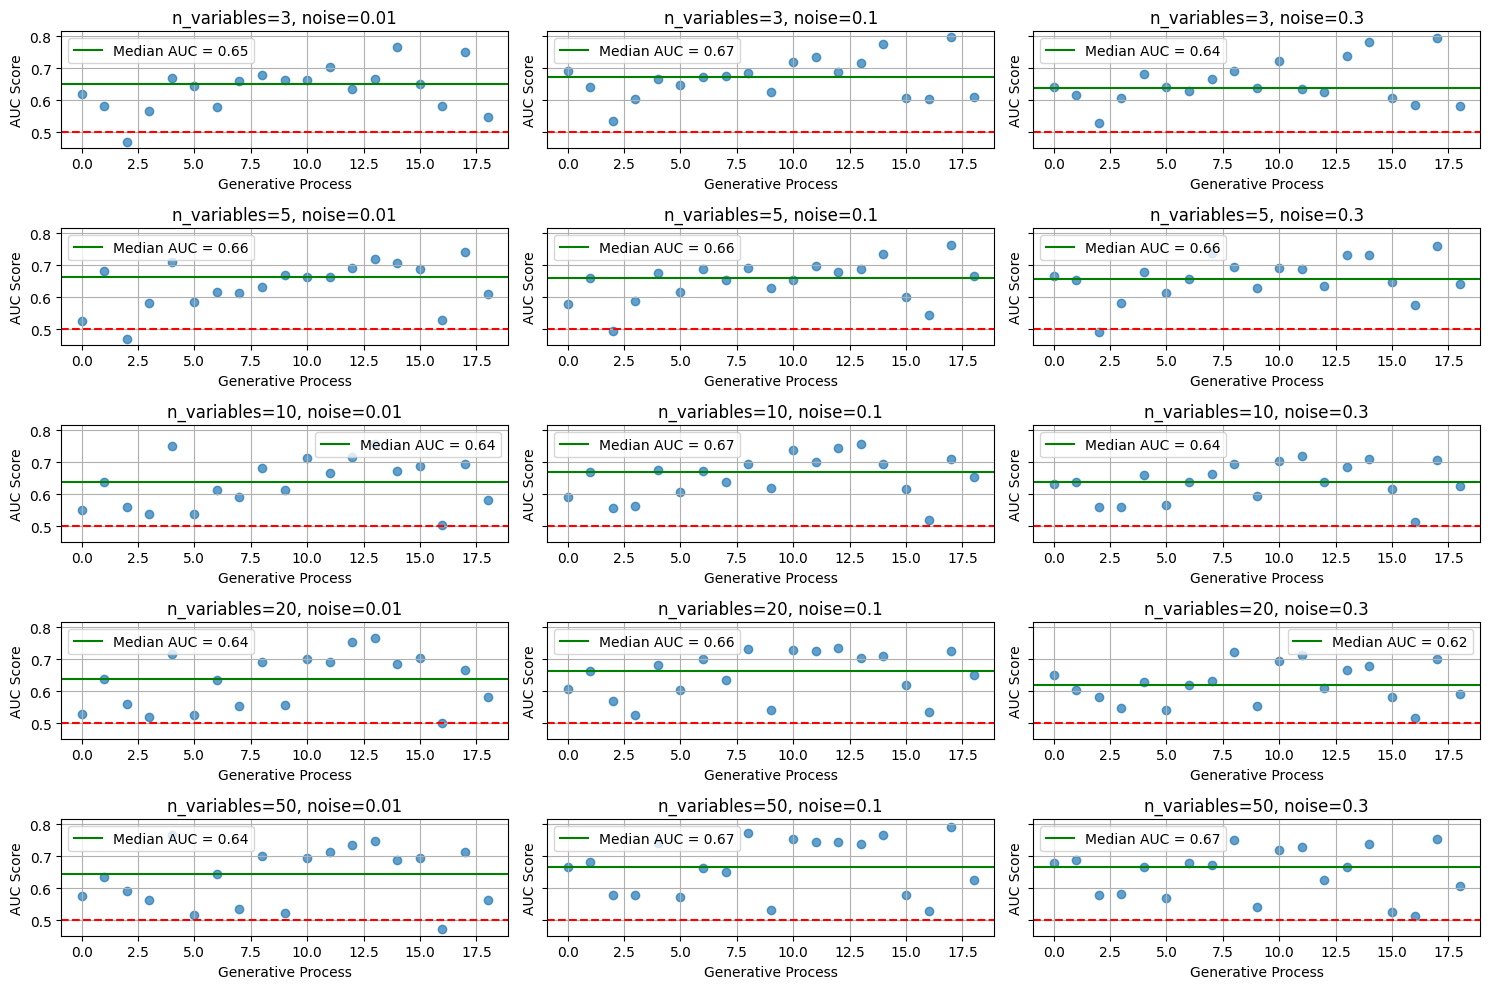

In [56]:
# Plot the updated AUC distributions with AUC line at 0.5
fig_updated = plot_auc_distributions(cross_validation_results)
plt.show()

# Are there all ts in every descriptor file?

In [23]:
import pandas as pd 

descriptors = {}
for n_variables in [3,5,10,20,50]:
        descriptors[n_variables] = {}
        for noise_std in [0.01, 0.1, 0.3]:
            
            output_folder = f'data_N{n_variables}_std{noise_std}/'
            file_name = 'descriptors_var.pkl'

            descriptors[n_variables][noise_std] = pd.read_pickle('../'+output_folder + file_name)



In [26]:

for n_variables in [3,5,10,20,50]:
    for noise_std in [0.01, 0.1, 0.3]:
        df = descriptors[n_variables][noise_std]
        print("Variables", n_variables,'noise', noise_std, end=' ')
        print(df.graph_id.unique())

Variables 3 noise 0.01 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

In [22]:
for n_variables in [3,5,10,20,50]:
    for noise_std in [0.01, 0.1, 0.3]:
        df = descriptors[n_variables][noise_std]
        print(df[df.graph_id == 965].shape[0])

15
15
15
27
27
27
60
60
60
60
60
60
60
60
60
